In [1]:
import pandas as pd

###### Processing Emissions from and Upsteam and Midstream Oil & Gas industry

* Emission data is present in six excel files. Each file represents a specific sector (upstream or downstream) and specif type of greenhouse gas (CO2, CH4, N2O).
* Within each file, there are eight sheets a separate sheet for each year. Starting from 2011 to 2018.
* Combine these sheets from excel files into a single data frame. Add a column to each of these data frames (file level) to indicate what type of emission it is, i.e, CO2 or CH4 or N2O.
* Also add a column to indicate what sector that excel data represents, whether it is Upstream or midstream.


In [2]:
#Read emission excel spreadsheets
FileList=['Midstream-CH4.xls','Midstream-CO2.xls','Midstream-N2O.xls','Upstream-CH4.xls','Upstream-CO2.xls','Upstream-N2O.xls']
folder_path = "Final Data Set/"

In [3]:
total_size = 0
df_list=[]
for file in FileList:
    file_path=folder_path+file
    
    fileName = file.split('.')[0].split('-')
    sector = fileName[0]
    gas = fileName[1]
    
    df = pd.read_excel(file_path, sheet_name=None,skiprows=[0,1,2,3,4,5])
    for year in df:
        df_key = sector+"_"+gas+"_"+year
        df_name=df_key+"_df"
        df_name = df[year]
        df_name['GAS']=gas
        df_name['SECTOR']=sector
        df_list.append(df_name)

# comine (union) all these dataframes into a single dataframe       
df_fullset = pd.concat(df_list)
# Some of the facilities are operated inder partnership, we need to allocate emission quantities to individual parent companies
df_fullset['PARENT COMPANIES']=df_fullset['PARENT COMPANIES'].str.split(';')
df_fullset=df_fullset.explode('PARENT COMPANIES')

regex=r'(?P<PARENT_COMPANY>[-\w\s\d,&./()#]+)([\(])(?P<CONTRIBUTION>[\(\d.]+)([%\)]*)'

df_fullset[['PARENT_COMPANY','CONTRIBUTION_PERCENT']]=df_fullset['PARENT COMPANIES'].str.extract(regex)[['PARENT_COMPANY','CONTRIBUTION']]

df_fullset[['GHG QUANTITY (METRIC TONS CO2e)','CONTRIBUTION_PERCENT']]=df_fullset[['GHG QUANTITY (METRIC TONS CO2e)','CONTRIBUTION_PERCENT']].apply(pd.to_numeric)

df_fullset['GHG_CONTRIBUTION']=df_fullset['GHG QUANTITY (METRIC TONS CO2e)']*df_fullset['CONTRIBUTION_PERCENT']*0.01

#Aggregate the data by Parent company, sector, reporting year and Emission type

df_Agg=df_fullset.groupby(['REPORTING YEAR','PARENT_COMPANY','GAS','SECTOR'])['GHG_CONTRIBUTION'].agg('sum').reset_index().sort_values(['PARENT_COMPANY','REPORTING YEAR'])

df_Agg['PARENT_COMPANY']=df_Agg['PARENT_COMPANY'].str.strip()

#2018 upstream rank
df_Agg_upstream=df_Agg[(df_Agg['REPORTING YEAR']==2018) & (df_Agg['SECTOR']=='Upstream')].groupby(['PARENT_COMPANY']).sum().sort_values('GHG_CONTRIBUTION',ascending=False).reset_index().reset_index().rename(columns={'index':'2018_UPSTREAM_RANK'})
df_Agg_upstream['2018_UPSTREAM_RANK']=df_Agg_upstream['2018_UPSTREAM_RANK']+1
df_Agg_upstream=df_Agg_upstream.drop(['REPORTING YEAR','GHG_CONTRIBUTION'],axis=1)
#df_Agg_upstream.head(10)

#2018 midstream rank
df_Agg_midstream=df_Agg[(df_Agg['REPORTING YEAR']==2018) & (df_Agg['SECTOR']=='Midstream')].groupby(['PARENT_COMPANY']).sum().sort_values('GHG_CONTRIBUTION',ascending=False).reset_index().reset_index().rename(columns={'index':'2018_MIDSTREAM_RANK'})
df_Agg_midstream['2018_MIDSTREAM_RANK']=df_Agg_midstream['2018_MIDSTREAM_RANK']+1
df_Agg_midstream=df_Agg_midstream.drop(['REPORTING YEAR','GHG_CONTRIBUTION'],axis=1)
df_Agg_midstream.head(10)


#2018 Overall rank
df_Agg_overall=df_Agg[(df_Agg['REPORTING YEAR']==2018)].groupby(['PARENT_COMPANY']).sum().sort_values('GHG_CONTRIBUTION',ascending=False).reset_index().reset_index().rename(columns={'index':'2018_OVERALL_RANK'})
df_Agg_overall['2018_OVERALL_RANK']=df_Agg_overall['2018_OVERALL_RANK']+1
df_Agg_overall=df_Agg_overall.drop(['REPORTING YEAR','GHG_CONTRIBUTION'],axis=1)
df_Agg_overall.head(10)


# Add ranks to Aggregated dataset
df_Agg_withRanks=pd.merge(df_Agg,df_Agg_upstream,on='PARENT_COMPANY',how='left')\
.merge(df_Agg_midstream,on='PARENT_COMPANY',how='left')\
.merge(df_Agg_overall,on='PARENT_COMPANY',how='left')\
.sort_values('2018_UPSTREAM_RANK')

#Fill uncalculated ranks to max rank
df_Agg_withRanks['2018_UPSTREAM_RANK']=df_Agg_withRanks['2018_UPSTREAM_RANK'].fillna(max(df_Agg_withRanks['2018_UPSTREAM_RANK'])+1)
df_Agg_withRanks['2018_MIDSTREAM_RANK']=df_Agg_withRanks['2018_MIDSTREAM_RANK'].fillna(max(df_Agg_withRanks['2018_MIDSTREAM_RANK'])+1)

#Keep a copy of processed data into a file
df_Agg_withRanks.to_csv('Emissions_aggregatedData.csv',index=False,sep='|')

In [4]:
df_Agg_withRanks.to_csv('Emissions_aggregatedData.csv',index=False,sep='|')

###### Processing the Emissons from other Industrial sectors

In [5]:
df_industry = pd.read_csv(folder_path+'IndustryWiseGHGEmissions.csv')
# Unpivot the Yearly data, put it in columner format
df_industry=pd.melt(df_industry, id_vars=['Industry Sector'], var_name='Year', value_name='Emission')
#Remove yearly totals
df_industry=df_industry[df_industry['Industry Sector']!='Total']
#Write it to a csv file
df_industry.to_csv('Emissions_OtherIndustries.csv',index=False,sep='|')

In [6]:
df_industry.sample(10)

,Industry Sector,Year,Emission
53,Chemical production and use,1995,82.757310
187,Production and use of fluorinated gases,2008,31.908324
92,Other industrial categories,1999,139.503545
214,Coal mining,2011,77.651185
2,Other industrial categories,1990,106.295020
116,Metal production,2001,91.652907
50,Fossil fuel combustion: carbon dioxide,1995,851.821778
73,Chemical production and use,1997,79.156425
131,Natural gas and petroleum systems,2003,247.444183
23,Chemical production and use,1992,72.788050


###### Oil and Gas production data processing

In [60]:
# Read Natural Gas production file
dict_gasProduction = pd.read_excel(folder_path+'NaturalGas Production.xls',sheet_name=[1,2], usecols=[0,1],skiprows=[0,1], names=['Date','Production BOE'])
df_gasProduction = pd.concat(dict_gasProduction.values())
df_gasProduction=df_gasProduction.groupby('Date').sum()
df_gasProduction['Product']='Natural Gas'
df_gasProduction['Production BOE']=df_gasProduction['Production BOE']*1000/6000

df_gas_annual=df_gasProduction.groupby(['Product',pd.Grouper(freq="Y")]).sum().reset_index()
df_gas_annual=df_gas_annual[df_gas_annual['Date']<'2020-01-01']
df_gas_annual.sample(5)


,Product,Date,Production BOE
7,Natural Gas,1980-12-31,3.644333e+06
37,Natural Gas,2010-12-31,4.659605e+06
19,Natural Gas,1992-12-31,3.825080e+06
27,Natural Gas,2000-12-31,4.175003e+06
43,Natural Gas,2016-12-31,5.527233e+06


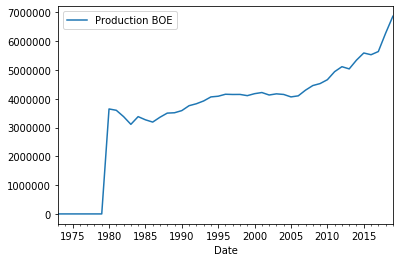

In [61]:
df_gas_annual.plot(kind='line',y='Production BOE',x='Date')

In [58]:
# Crude oil production
df_CrudeProduction=pd.read_excel(folder_path+'CrudeOil Production.xls',sheet_name=1, usecols=[0,1],skiprows=[0,1], names=['Date','Production BOE'])
df_CrudeProduction['Product']='Crude'
df_CrudeProduction['Production BOE']=df_CrudeProduction['Production BOE']*1000
df_CrudeProduction=df_CrudeProduction.set_index('Date')

df_crude_annual=df_CrudeProduction.groupby(['Product',pd.Grouper(freq="Y")]).sum().reset_index()
df_crude_annual=df_crude_annual[df_crude_annual['Date']<'2020-01-01']
df_crude_annual.sample(5)


,Product,Date,Production BOE
39,Crude,1959-12-31,2574590000
43,Crude,1963-12-31,2752723000
98,Crude,2018-12-31,4011519000
14,Crude,1934-12-31,908065000
59,Crude,1979-12-31,3121310000


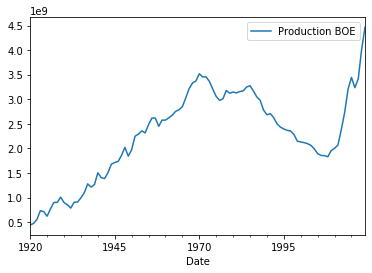

In [59]:
df_crude_annual.plot(kind='line',y='Production BOE',x='Date')

In [55]:
#Put both Datasets together in columner format
df_annual_production = pd.concat([df_crude_annual,df_gas_annual])

In [56]:
df_annual_production.to_csv('Processed_AnnualProductionData.csv', sep='|')

In [57]:
df_annual_production.sample(10)

,Product,Date,Production MMcf
49,Crude,1969-12-31,3371751.0
74,Crude,1994-12-31,2431476.0
3,Crude,1923-12-31,732407.0
8,Crude,1928-12-31,901474.0
20,Natural Gas,1993-12-31,23532683.0
7,Crude,1927-12-31,901129.0
28,Crude,1948-12-31,2020185.0
41,Crude,1961-12-31,2621758.0
63,Crude,1983-12-31,3170999.0
69,Crude,1989-12-31,2778772.0


In [25]:
#str1='EXXONMOBIL CORP (36.4%)'
#Burlington Resources Oil & Gas Co LP (46.070631%); Moncrief Partners, L.P. (4.850469%); W. A. Moncrief, Jr.  (30.012895%); Oxy Y-1 / Rio de Viento, Inc. (2.405861%); Plains Exploration & Prod. / Pogo Producing Company (13.600789%); ExxonMobil Production (1.055989%)
s = pd.Series(['ANADARKO PETROLEUM CORP (49%)',' APACHE CORP (12.31%)',' APACHE CORP (4.2%)',' Apache Corporation (2.25%)',' Arena Energy, LLC (1.34%)',' Arena Entergy, LLC (1.34%)',' Ariel Exploration Inc (1%)',' BP AMERICA INC (26.4%)',' BP America Production Company (19.43%)',' CHEVRON CORP (1.2%)',' CHEVRON CORP (1.9%)',' CHEVRON CORP (10.52%)',' CHEVRON CORP (2.1%)',' CHEVRON CORP (21%)',' CHEVRON CORP (6.05%)',' CONOCO PHILLIPS (36.1%)',' COPREX LLC (25%)',' Chevron Pipeline Company (30%)',' Chevron Services Co. (1.2652%)',' Chevron Texaco Corporation (17%)',' Cimarex Energy Co #774031 (1%)',' Conoco Philips Company (14%)',' ConocoPhillips Company (50%)',' DCP MIDSTREAM, LP (1.14%)',' DCP MIDSTREAM, LP (20%)',' DCP MIDSTREAM, LP (6.9%)',' DCP Midstream Partners, LP (40%)',' DEVON ENERGY (10%)',' DEVON ENERGY (17.98%)',' DEVON ENERGY (22.5%)',' Dabb Energy Company (1%)',' Devon Energy Production Co LP (1%)',' Devon Energy Production Co LP (12%)',' EAGLE ROCK ENERGY PARTNERS, LP (25%)',' ENI Petroleum (1.23%)',' EXXONMOBIL CORP (10.52%)',' EXXONMOBIL CORP (14%)',' EXXONMOBIL CORP (21.02%)',' EXXONMOBIL CORP (48.2%)',' Eagle Rock GOM, L.P. (1.67%)',' Eleanor Whitcomb, Robert Keady, & Linda K. Boyd Trustees (1.4887%)',' Enterprise Gas Processing (15.54%)',' Enterprise Gas Processing, LLC (50%)',' Enterprise Gas Processing, LLC (64.52%)',' Exxon Mobil Corporation (16.87%)',' Exxon Mobil Production Company (3.04%)',' Exxon Mobile Corporation (12%)',' ExxonMobil Production (1.055989%)',' GEO R BROWN PARTNERSHIP LP (1.24258%)',' GIP-B1 Master Partnership, L.P.',' GIP-C Holding Partnership, L.P.',' Global Infrastructure Partners - A (50%)',' HESS CORP (24.41%)',' Hilcorp Energy Company (1.39%)',' JOHNSON AND LINDLEY, INC (15%)',' Jayne Wrightsman Company (2%)',' Kinder Morgan (25%)',' Kinder Morgan (49%)',' Kinder Morgan (50%)',' LOUIS DREYFUS CORP INC (19.53%)',' LP 224 LLC (5.587576%)',' Landreth Company Stockholders (1%)',' Leed Petroleum LLC (2.56%)',' Legacy Reserves Operating LP (1%)',' Legacy Reserves Operating LP (2%)',' MARATHON PETROLEUM CO LP (4%)',' MARKWEST ENERGY PARTNERS, LP (40%)',' MARUBENI INTERNATIONAL (35.7%)',' MERIT ENERGY CO (25.24566%)',' MURPHY EXPLORATION (ALASKA), INC (1.4%)',' Marathon Oil Company (34%)',' Marathon Oil Company (50%)',' Mobile Producing Texas & New Mexico Inc (1%)',' Moncrief Partners, L.P. (4.850469%)',' NGL Ventures LLC (16.6%)',' Noble Energy, Inc (1.275%)',' Non-ExxonMobil Interests (43%)',' OCCIDENTAL PERMIAN LTD (32.43532%)',' OCCIDENTAL PETROLEUM CORP (20%)',' OCCIDENTAL PETROLEUM CORP (39.1%)',' ONEOK Partners, L.P. (10%)',' Oldham Family LLC (1%)',' Oxy (28.64244%)',' Oxy Y-1 / Rio de Viento, Inc. (2.405861%)',' P&S Project I, LLC (25%)',' PENSARELI INC (1.188213%)',' PERMIAN BASIN LTD PTP (48.20214%)',' Permian Basin Limited Partnership (35%)',' Philip T. Sharples Trust (4.2822%)',' Phillips 66 (10%)',' Phillips 66 (25%)',' Phillips 66 Company (40%)',' Phillips66 Company (22.5%)',' Plains Exploration & Prod. / Pogo Producing Company (13.600789%)',' QUANTUM RESOURCES MGT LLC (3.239535%)',' REGENCY ENERGY PARTNERS LP (30%)',' RESOURCE STRATEGIES (2.196126%)',' RUDY RESOURCES LP (1.8079%)',' Regency Midcontinent Express Pipeline, LLC (49.9%)',' SPECTRA ENERGY CORP (10%)',' SPECTRA ENERGY CORP (25%)',' SPECTRA ENERGY CORP (44.92375%)',' SPECTRA ENERGY CORP (50%)',' Sharples Associates (1.4109%)',' Spectra Energy Corp (10%)',' Spectra Energy Corporation (1%)',' Spectra Energy Partners, LP (49%)',' Spectra Energy Southeast Supply Header, LLC (50%)',' TARGA RESOURCES INC (38.75%)',' Targa Midstream Services, L.P.  (10.2875%)',' Targa Midstream Services, L.P. (4.75%)',' Union Exploration Partners Ltd. (1.12%)',' VERESEN INC (50%)',' W & T Offshore, Inc. (5.17%)',' W. A. Moncrief, Jr.  (30.012895%)',' WHITING OIL AND GAS CORP (1.1037%)',' WHITING OIL AND GAS CORP (4.613916%)',' Williams (31.45%)',' Williams Co. (25%)',' XTO ENERGY, INC (23%)',' ZPZ Delaware I LLC (23%)','AGL RESOURCES INC (100%)','AKA ENERGY GROUP, LLC (100%)','ANADARKO PETROLEUM CORP (100%)','ANR Pipeline Company (100%)','ARROWHEAD PIPELINE, LP (100%)','ATLAS PIPELINE PARTNERS, LP (100%)','ATLAS PIPELINE PARTNERS, LP (60%)','ATMOS ENERGY CORP (100%)','AUX SABLE LIQUID PRODUCTS  (100%)','Acadian Gas Pipeline System (100%)','Access Midstream Partners LP (100%)','Access Midstream Partners, L.P. (100%)','Algonquin Gas Transmission, LLC (100%)','American Midstream Partners, LP (100%)','Anadarko Petroleum Corporation (100%)','Aux Sable Midstream LLC (100%)','Azure Midstream Energy, LLC (100%)','BHP Billiton Petroleum (North America) Inc.  (75%)','BHP Billiton Petroleum Holdings LLC (100%)','BONANZA CREEK ENERGY, INC (100%)','BP AMERICA INC (100%)','BP AMERICA INC (67.92%)','BP AMERICA INC (98.6%)','BP America Production Company (50%)','BreitBurn Energy Partners L.P. (100%)','Burlington Resources Oil & Gas Co LP (46.070631%)','CEDAR BAYOU FRACTIONATORS, LP (100%)','CHENIERE ENERGY INC (100%)','CHEVRON CORP (100%)','CHEVRON CORPORATION (100%)','CHEVRON CORPORATION (51.54842%)','CHEVRON CORPORATION (62.029736%)','CHEVRON CORPORATION (68.069512%)','CMS ENERGY CORP (100%)','CNX Gas Company (100%)','CONOCO PHILLIPS (100%)','CRESTWOOD MIDSTREAM PARTNERS LP (100%)','CROSSTEX ENERGY SERVICES LP (100%)','CROSSTEX PERMIAN LLC (100%)','Castleton Commodities International LLC (100%)','CenterPoint Energy Resources CORPORATION (100%)','CenterPoint Energy Resources Corp (100%)','CenterPoint Energy Southeastern Pipeline Holdings, LLC (50%)','CenterPoint Energy Southeastern Pipelines Holdings, LLC (50%)','CenterPoint Energy Southeastern Piplines Holdings, LLC (50%)','Centerpoint Energy Resources Corp (100%)','Chevron Corporation (100%)','Coronado Midstream LLC (100%)','Costar Midstream, LLC (100%)','CostarMidstream, LLC (100%)','Crosstex CCNG Processing Ltd (100%)','Crosstex CCNG Processing Ltd. (100%)','Crosstex North Texas Gathering, LP (100%)','Crosstex North Texas Pipeline, LP (100%)','Crosstex Processing Services, LLC (100%)','DCP MIDSTREAM HOLDING, LLC (62.5%)','DCP MIDSTREAM PARTNERS, LP (100%)','DCP MIDSTREAM PARTNERS, LP (50%)','DCP MIDSTREAM PARTNERS, LP (80%)','DCP Midstream Partners, LP (100%)','DCP Midstream Partners, LP (80%)','DENBURY RESOURCES, INC (100%)','DEVON ENERGY (100%)','DEVON ENERGY (38.75%)','DEVON GAS SERVICES, LP (100%)','DOMINION RESOURCES INC (100%)','DOMINION RESOURCES INC (50%)','DTE ENERGY CO (100%)','Destin Pipeline Company LLC (100%)','Dow (50%)','EAGLE ROCK ENERGY PARTNERS, LP (100%)','EFS MIDSTREAM LLC  (100%)','EFS MIDSTREAM LLC (100%)','EFS Midstream LLC (100%)','EL PASO CORP (6.03%)','ENABLE MIDSTREAM PARTNERS, LP (100%)','ENBRIDGE INC (50%)','ENERGY TRANSFER PARTNERS, LP (100%)','ENERGY TRANSFER PARTNERS, LP (50%)','ENERGY TRANSFER PARTNERS, LP (70%)','ENRIDGE INC (50%)','ENTERPRISE LLC (42.2%)','ENTERPRISE PRODUCTS PARTNERS, LP (100%)','EOG RESOURCES, INC (100%)','EQT CORP (100%)','EXCO/HGI JV Assets, LLC (100%)','EXTERRAN HOLDINGS, INC (100%)','EXXONMOBIL CORP (36.4%)','East Tennessee Natural Gas, LLC (100%)','Egan Hub Storage, LLC (100%)','El Paso Pipeline Partners, L.P (100%)','El Paso Pipeline Partners, L.P. (100%)','El Paso Pipeline Partners, LP. (100%)','El Paso Pipelines Partners, L.P. (100%)','El Paso Ruby Holding Company, L.L.C. (50%)','Enbridg Energy Partners, L.P. (100%)','Enbridge Energy Partners, L.P.  (100%)','Enbridge Energy Partners, L.P. (100%)','Enbridge Inc (100%)','Encana Oil & Gas (USA) Inc. (100%)','Enterprise Field Services, LLC (100%)','Enterprise Gas Processing, LLC (100%)','Enterprise Gas Processing, LLC (32.25%)','Enterprise Gas Processing, LLC (50%)','Enterprise Gas Processing, LLC (64.19%)','Enterprise Gas Processing, LLC (66%)','Enterprise Hydrocarbons, L.P. (100%)','Enterprise Hydrocarbons, LP (100%)','Enterprise Products LLC (100%)','Enterprise Products Operating LLC (100%)','Enterprise Products Operating, LLC (100%)','Enterprise Products Operating, LLC (75%)','Escambia Asset Co. LLC (78.14%)','Exxon Mobil Production Company (8.52%)','ExxonMobil (100%)','ExxonMobil Corporation (100%)','ExxonMobil Corporation (57%)','FLORIDA GAS TRANSMISSION CO (100%)','FREEPORT LNG DEVELOPMENT, LP (100%)','Formosa Hydrocarbons Company, Inc. (100%)','GDF SUEZ North America (100%)','Gas Transmission Services Company LLC (100%)','Great Lakes Gas Transmission Company (100%)','HUNT CONSOLIDATED, INC (100%)','Hess Corporation (100%)','Hiland Partners LP (100%)','Hoover Energy Partners LP (100%)','INTEGRYS ENERGY GROUP INC (100%)','IROQUOIS GAS TRANSMISSION SYSTEM, LP (100%)','Inergy West Coast LLC (100%)','KOCH INDUSTRIES INC (100%)','Kinder Morgan (100%)','Kinder Morgan Energy Partners (100%)','Kinder Morgan Energy Partners L.P. (100%)','Kinder Morgan Energy Partners, L.P (100%)','Kinder Morgan Energy Partners, L.P.  (100%)','Kinder Morgan Energy Partners, L.P. (100%)','Kinder Morgan Energy Partners. L.P. (100%)','Kinder Morgan Operating Limited Partnership "A" (50%)','Kinder Morgen Energy Partners, L.P. (100%)','Kinetica Partners LLC (100%)','LOEWS CORP (100%)','Linn Energy, LLC  (100%)','MARKWEST ENERGY PARTNERS, LP (100%)','MARLIN MIDSTREAM, LLC (100%)','MDU RESOURCES GROUP INC (100%)','MERIT ENERGY CO, LLC (100%)','MID-AMERICAN ENERGY HOLDINGS CO (100%)','MORGAN STANLEY IP Southern Star LLC (100%)','MUSTANG FUEL CORP (100%)','Maritimes & Northeast Pipeline, LLC (100%)','MarkWest Energy Partners, LP (100%)','Marlin Midstream, LLC (100%)','Monarch Natural Gas, LLC (100%)','Morgan Stanley IP  Southern Star LLC (100%)','Morgan Stanley IP Southern Star LLC (100%)','NATIONAL FUEL GAS CO (100%)','NISOURCE INC (100%)','NORTHERN NATURAL GAS CO (100%)','NORTHWESTERN ENERGY CORP (100%)','Niska Gas Storage (100%)','NorTex Midstream Partners, LLC (100%)','Northern Natural Gas Company (100%)','Nuevo Midstream, LLC (100%)','OCCIDENTAL PETROLEUM CORP (100%)','OCCIDENTAL PETROLEUM CORP (53%)','OCCIDENTAL PETROLEUM CORP (54%)','OCCIDENTAL PETROLEUM CORP (57.3%)','OCCIDENTAL PETROLEUM CORP (86.1%)'
               ,'OCCIDENTAL PETROLEUM CORP (93.95%)','ONEOK Partners, L.P.  (100%)','ONEOK Partners, L.P. (100%)','ONEOK Partners, L.P. (70%)','ONEOK Partners, L.P. (80%)','ONEOK Partnership, L.P. (100%)','Occidental Permian LTD (100%)','PETRO-HUNT LLC (70.69385%)','PIONEER NATURAL RESOURCES USA, INC (100%)','PIONEER NATURAL RESOURCES USA, INC (51%)','PIPECO LLC (100%)','PSI Midstream Partners, L.P. (100%)','PVR MIDSTREAM LLC (100%)','Pacific Gas and Electric Company (100%)','Permian Basin Limited Partnership (76%)','Phillips 66 (44.92375%)','Phillips 66 (50%)','Plains All American Pipeline, GP (100%)','Plains All American Pipeline, LP (100%)','Plains LPG Services (100%)','Plains Natural Gas Storage, LLC (100%)','Port Parre Investments, LLC d/b/a Bobcat Gas Stora (100%)','QEP RESOURCES INC (100%)','QUANTUM RESOURCES MANAGEMENT, LLC (100%)','QUESTAR CORP (100%)','REGENCY ENERGY PARTNERS LP (100%)','Ranch Westex JV LLC (100%)','Rockies Express Holdings, LLC (50%)','SCANA CORP (100%)','SEMPRA ENERGY (100%)','SEMPRA ENERGY INC (100%)','SHELL OIL CO (51.8%)','SOUTHCROSS GATHERING, LTD (100%)','Sempra Energy (100%)','Southcross Gathering, Ltd (100%)','Southcross Processing LLC (100%)','Southern Ute Indian Tribe (51%)','Superior Pipeline Company, LLC. (100%)','Superiror Pipeline Company, LLC (100%)','TARGA RESOURCES CORPORATION (100%)','TARGA RESOURCES Corporation (100%)','Tallgrass Operations, LLC (100%)','Targa Resources Corporation (100%)','Texas Eastern Transmission, L.P. (100%)','Texstar Midstream Services, LP (100%)','Thunder Creek Gas Services, LLC (100%)','TransCanada Northern Border Inc. (100%)','VAL VERDE GAS GATHERING CO LP (100%)','VECTOR PIPELINE, LP (100%)','Vanguard Natural Resources, LLC (100%)','W&T Offshore, Inc. (64.3%)','WGR Operating LP (100%)','WHITING PETROLEUM CORP (100%)','WILLIAMS PARTNERS, LP (100%)','WILLIAMS PARTNERS, LP (50%)','WILLIAMS PARTNERS, LP (60%)','WTG BENEDUM JOINT VENTURE (100%)','WTG GAS PROCESSING, LP (100%)','WTG Jameson, L.P. (100%)','Wildcat Midstream Caddo, LLC (100%)','Yates Petroleum Corporation (100%)','loe (100%)'])
s

0            ANADARKO PETROLEUM CORP (49%)
1                     APACHE CORP (12.31%)
2                       APACHE CORP (4.2%)
3               Apache Corporation (2.25%)
4                Arena Energy, LLC (1.34%)
                      ...                 
347          WTG GAS PROCESSING, LP (100%)
348               WTG Jameson, L.P. (100%)
349    Wildcat Midstream Caddo, LLC (100%)
350     Yates Petroleum Corporation (100%)
351                             loe (100%)
Length: 352, dtype: object

In [29]:
regex=r'(?P<PARENT_COMPANY>[-\w\s\d,&./()#]+)([\(])(?P<CONTRIBUTION>[\(\d.]+)([%\)]*)'
df_textAnalysis = s.str.extract(regex)[['PARENT_COMPANY','CONTRIBUTION']]
df_textAnalysis['NameLength'] = df_textAnalysis['PARENT_COMPANY'].str.len()
df_textAnalysis.sort_values('NameLength')

,PARENT_COMPANY,CONTRIBUTION,NameLength
259,,50,1.0
351,loe,100,4.0
190,Dow,50,4.0
82,Oxy,28.64244,5.0
205,EQT CORP,100,9.0
...,...,...,...
165,CenterPoint Energy Southeastern Piplines Holdi...,50,55.0
164,CenterPoint Energy Southeastern Pipelines Hold...,50,56.0
40,"Eleanor Whitcomb, Robert Keady, & Linda K. Bo...",1.4887,58.0
49,NaN,NaN,NaN
